In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

Будем работать с данными агрегатора такси [Sigma Cabs](https://www.kaggle.com/datasets/arashnic/taxi-pricing-with-mobility-analytics). В зависимости от характеристик поездки требуется предсказать один из трех типов повышенного ценообразования: [1, 2, 3]. Таким образом, это поможет компании оптимально мэтчить такси и клиентов. 

In [2]:
df = pd.read_csv('sigma_cabs.csv')
df.shape

(131662, 14)

In [3]:
# Занесем индекс колонку
df = df.set_index('Trip_ID')
df.head()

,Trip_Distance,Type_of_Cab,Customer_Since_Months,Life_Style_Index,Confidence_Life_Style_Index,Destination_Type,Customer_Rating,Cancellation_Last_1Month,Var1,Var2,Var3,Gender,Surge_Pricing_Type
Trip_ID,,,,,,,,,,,,,
T0005689460,6.77,B,1.0,2.42769,A,A,3.90500,0,40.0,46,60,Female,2
T0005689461,29.47,B,10.0,2.78245,B,A,3.45000,0,38.0,56,78,Male,2
T0005689464,41.58,NaN,10.0,NaN,NaN,E,3.50125,2,NaN,56,77,Male,2
T0005689465,61.56,C,10.0,NaN,NaN,A,3.45375,0,NaN,52,74,Male,3
T0005689467,54.95,C,10.0,3.03453,B,A,3.40250,4,51.0,49,102,Male,2


Описание признаков:

1. **Trip_ID**: ID for TRIP
2. **Trip_Distance**: The distance for the trip requested by the customer
3. **TypeofCab**: Category of the cab requested by the customer
4. **CustomerSinceMonths**: Customer using cab services since n months; 0 month means current month
5. **LifeStyleIndex**: Proprietary index created by Sigma Cabs showing lifestyle of the customer based on their behaviour
6. **ConfidenceLifeStyle_Index**: Category showing confidence on the index mentioned above
7. **Destination_Type**: Sigma Cabs divides any destination in one of the 14 categories.
8. **Customer_Rating**: Average of life time ratings of the customer till date
9. **CancellationLast1Month**: Number of trips cancelled by the customer in last 1 month
10. **Var1**, **Var2** and **Var3**: Continuous variables masked by the company. Can be used for modelling purposes
11. **Gender**: Gender of the customer

**SurgePricingType**: Target (can be of 3 types)


### EDA 
Заполним пропуски в вещественных признаках медианой, а в категориальных - самым популярным классом. Изобразим марицу корреляций и выведите топ5 пар самых коррелированных признаков.

In [4]:
numeric_columns = df.columns[df.dtypes != np.object].drop('Surge_Pricing_Type')
categorical_columns = df.columns[df.dtypes == np.object]

for col in numeric_columns:
    df[col].fillna(df[col].median(), inplace=True)
    
for col in categorical_columns:
    df[col].fillna(df[col].value_counts(sort=True).index[0], inplace=True)
    
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 131662 entries, T0005689460 to T0005908514
Data columns (total 13 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Trip_Distance                131662 non-null  float64
 1   Type_of_Cab                  131662 non-null  object 
 2   Customer_Since_Months        131662 non-null  float64
 3   Life_Style_Index             131662 non-null  float64
 4   Confidence_Life_Style_Index  131662 non-null  object 
 5   Destination_Type             131662 non-null  object 
 6   Customer_Rating              131662 non-null  float64
 7   Cancellation_Last_1Month     131662 non-null  int64  
 8   Var1                         131662 non-null  float64
 9   Var2                         131662 non-null  int64  
 10  Var3                         131662 non-null  int64  
 11  Gender                       131662 non-null  object 
 12  Surge_Pricing_Type           131662 non-null  in

In [5]:
def get_redundant_pairs(df):
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n:int=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

Var2              Var3                0.683437
Trip_Distance     Life_Style_Index    0.468332
Life_Style_Index  Var3                0.303324
Customer_Rating   Var2                0.302968
Trip_Distance     Var3                0.231706
dtype: float64

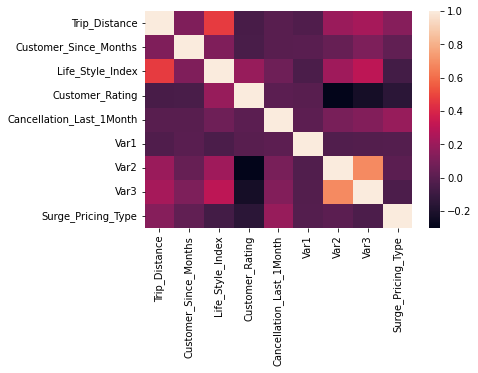

In [6]:
sns.heatmap(df.corr())
get_top_abs_correlations(df[numeric_columns], 5)

In [7]:
df.describe(include=object)

,Type_of_Cab,Confidence_Life_Style_Index,Destination_Type,Gender
count,131662,131662,131662,131662
unique,5,3,14,2
top,B,B,A,Male
freq,51346,60548,77597,93900


In [8]:
df = pd.get_dummies(data=df, columns=categorical_columns, drop_first=True)
df.head()

,Trip_Distance,Customer_Since_Months,Life_Style_Index,Customer_Rating,Cancellation_Last_1Month,Var1,Var2,Var3,Surge_Pricing_Type,Type_of_Cab_B,...,Destination_Type_F,Destination_Type_G,Destination_Type_H,Destination_Type_I,Destination_Type_J,Destination_Type_K,Destination_Type_L,Destination_Type_M,Destination_Type_N,Gender_Male
Trip_ID,,,,,,,,,,,,,,,,,,,,,
T0005689460,6.77,1.0,2.42769,3.90500,0,40.0,46,60,2,1,...,0,0,0,0,0,0,0,0,0,0
T0005689461,29.47,10.0,2.78245,3.45000,0,38.0,56,78,2,1,...,0,0,0,0,0,0,0,0,0,1
T0005689464,41.58,10.0,2.79805,3.50125,2,61.0,56,77,2,1,...,0,0,0,0,0,0,0,0,0,1
T0005689465,61.56,10.0,2.79805,3.45375,0,61.0,52,74,3,0,...,0,0,0,0,0,0,0,0,0,1
T0005689467,54.95,10.0,3.03453,3.40250,4,51.0,49,102,2,0,...,0,0,0,0,0,0,0,0,0,1


In [9]:
X = df.drop('Surge_Pricing_Type', axis=1)
y = df['Surge_Pricing_Type'].values

### Training

In [10]:
np.random.seed(2022)

from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [11]:
X_train, X_test, y_train, y_test  = train_test_split(X, y, 
                                                     test_size=0.2, 
                                                     shuffle=True, 
                                                     random_state=2022)

In [12]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

pipe = Pipeline([('scaler', StandardScaler()),
                 ('one_vs_all', OneVsRestClassifier(estimator=LogisticRegression()))
                ])
pipe.fit(X_train, y_train)
print(classification_report(y_test, pipe.predict(X_test), digits=3))

              precision    recall  f1-score   support

           1      0.723     0.542     0.619      5372
           2      0.636     0.834     0.722     11349
           3      0.741     0.571     0.645      9612

    accuracy                          0.679     26333
   macro avg      0.700     0.649     0.662     26333
weighted avg      0.692     0.679     0.673     26333



In [13]:
param_grid = {'one_vs_all__estimator__penalty': ['l1', 'l2', 'elasticnet'],
              'one_vs_all__estimator__C': [0.001, 0.01, 0.1, 1]}

In [14]:
from sklearn.model_selection import GridSearchCV

search = GridSearchCV(estimator=pipe, param_grid=param_grid, cv=5)
search.fit(X_train, y_train)
search.best_params_

pipe.set_params(one_vs_all__estimator__penalty = search.best_params_['one_vs_all__estimator__penalty'],
                one_vs_all__estimator__C = search.best_params_['one_vs_all__estimator__C'])
pipe.fit(X_train, y_train)
print(classification_report(y_test, pipe.predict(X_test), digits=3))

              precision    recall  f1-score   support

           1      0.742     0.534     0.621      5372
           2      0.635     0.839     0.723     11349
           3      0.742     0.576     0.649      9612

    accuracy                          0.681     26333
   macro avg      0.706     0.650     0.664     26333
weighted avg      0.696     0.681     0.675     26333



Изобразите три калибровочные кривые для Logistic Classifier: 0-vs-rest, 1-vs-rest, 2-vs-rest. Хорошо ли откалиброван обученный классификатор? 

Заметьте, что `predict_proba` возвращает список из вероятностей для всех наших классов!

from sklearn.calibration import CalibrationDisplay
from sklearn.calibration import calibration_curve

CalibrationDisplay.from_predictions(y_test, pipe.predict_proba(X_test)[:, 1])

In [15]:
### Создание полиномиальных признаков

X_polinomial = X.copy()

for col in numeric_columns:
    for power in [2, 3, 4]:
        
        to_add = (X_polinomial[col]**power).to_frame().rename({col:f"{col}_{power}"}, axis=1)
        X_polinomial = pd.concat((X_polinomial, to_add), axis=1)

In [16]:
X_pol_train, X_pol_test, y_train, y_test  = train_test_split(X_polinomial, y, 
                                                             test_size=0.2, 
                                                             shuffle=True, 
                                                             random_state=2022)

In [17]:
pipe.fit(X_pol_train, y_train)
print(classification_report(y_test, pipe.predict(X_pol_test), digits=3))

              precision    recall  f1-score   support

           1      0.748     0.532     0.622      5372
           2      0.636     0.837     0.723     11349
           3      0.741     0.584     0.653      9612

    accuracy                          0.682     26333
   macro avg      0.708     0.651     0.666     26333
weighted avg      0.697     0.682     0.677     26333



По аналогии с первым заданием изобразите три калибровочные кривые. Стало ли лучше?

**Задание 3.** Обучите на датасете без полиномиальных признаков One-vs-One `SGDClassifier` из `sklearn.linear_model`, который использует стохастический градиентный спуск (узнаете о нем позже) и может обучать как `SVM`, так и, например, `LogReg`, если указать в качестве параметра `loss` либо `hinge`, либо `log` соответственно!

Посчитайте precision, recall, f1-score и усредните по всем классам с помощью micro, macro и weighted avg.

In [18]:
X_train, X_test, y_train, y_test  = train_test_split(X, y, 
                                                     test_size=0.2, 
                                                     shuffle=True, 
                                                     random_state=2022)

In [19]:
from sklearn.linear_model import SGDClassifier
from sklearn.multiclass import OneVsOneClassifier

model = SGDClassifier(loss='hinge')
pipe = Pipeline([('scaler', StandardScaler()),
                 ('one_vs_one', OneVsOneClassifier(estimator=model))
                ])
pipe.fit(X_train, y_train)
print(classification_report(y_test, pipe.predict(X_test), digits=3))

              precision    recall  f1-score   support

           1      0.748     0.521     0.614      5372
           2      0.626     0.870     0.728     11349
           3      0.756     0.536     0.627      9612

    accuracy                          0.677     26333
   macro avg      0.710     0.642     0.656     26333
weighted avg      0.698     0.677     0.668     26333



Подберите оптимальные гиперпараметры модели с помощью `GridSearchCV()`. При этом переберите всевозможные функции потерь. Таким образом, при `loss = 'hinge'`, мы обучим SVM, при `loss = 'log'` мы обучим логистическую регрессию и т.д.

Используйте прием с Кросс-Валидацией при подборе параметров, как ранее, а также замерьте метрики на тесте.

In [20]:
param_grid = {'one_vs_one__estimator__loss': ['hinge', 'log', 'modified_huber'],
              'one_vs_one__estimator__penalty': ['l1', 'l2'],
              'one_vs_one__estimator__alpha': [0.001, 0.01, 0.1]}

In [21]:

search = GridSearchCV(estimator=pipe, param_grid=param_grid, cv=5)
search.fit(X_train, y_train)
search.best_params_

{'one_vs_one__estimator__alpha': 0.1,
 'one_vs_one__estimator__loss': 'modified_huber',
 'one_vs_one__estimator__penalty': 'l2'}

In [22]:
pipe.set_params(one_vs_one__estimator__alpha=search.best_params_['one_vs_one__estimator__alpha'],
                one_vs_one__estimator__loss=search.best_params_['one_vs_one__estimator__alpha'],
                one_vs_one__estimator__penalty=search.best_params_['one_vs_one__estimator__penalty'])

print(classification_report(y_test, pipe.predict(X_test), digits=3))

              precision    recall  f1-score   support

           1      0.748     0.521     0.614      5372
           2      0.626     0.870     0.728     11349
           3      0.756     0.536     0.627      9612

    accuracy                          0.677     26333
   macro avg      0.710     0.642     0.656     26333
weighted avg      0.698     0.677     0.668     26333

